In [1]:
#!pip install segmentation-models

In [1]:
import tensorflow as tf
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from sklearn.model_selection import train_test_split

import sys
import os
import datetime

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
# only allocate what is needed (using for gpu memory testing)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## open patches

In [3]:
folder_path = 'patches'
bf_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp2_patch_bf.tiff'))
greenc_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp2_patch_gc.tiff'))
mask_patches = tifffile.imread(os.path.join(folder_path, '53_gut_exp2_patch_mask.tiff'))

In [4]:
print(bf_patches.shape)
print(greenc_patches.shape)
print(mask_patches.shape)

(892, 256, 256)
(892, 256, 256)
(892, 256, 256)


In [5]:
combined_array = np.stack((bf_patches, greenc_patches), axis=-1)
combined_array.shape

(892, 256, 256, 2)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(combined_array, mask_patches, test_size = 0.20, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(713, 256, 256, 2)
(179, 256, 256, 2)


In [7]:
y_train = np.stack((y_train,)*1, axis=-1)
print(y_train.shape)

(713, 256, 256, 1)


In [8]:
y_test = np.stack((y_test,)*1, axis=-1)
print(y_test.shape)

(179, 256, 256, 1)


In [9]:
#New generator with rotation where interpolation that comes with rotation are thresholded in masks.
#This gives a binary mask rather than a mask with interpolated values.
seed=24
batch_size = 32

img_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))
                         #featurewise_center = True,
                         #featurewise_std_normalization = True)#,
                         #preprocessing_function = lambda x: x*np.random.uniform(0.95, 1.05))
                         #brightness_range = (0.95,1.05))


mask_data_gen_args = dict(rotation_range=0,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='nearest',
                         brightness_range = (0.95,1.05),
                         preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed,batch_size = batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed,batch_size = batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train, seed=seed,batch_size = batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed,batch_size = batch_size)

/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:931: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (713, 256, 256, 2) (2 channels).
  warnings.warn(
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (713, 256, 256, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/shared/centos7/anaconda3/2021.07-TF/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:120: UserWarning: NumpyArrayIterator is set to use the data format conven

In [10]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_gen = my_image_mask_generator(image_generator,mask_generator)
test_gen = my_image_mask_generator(valid_img_generator,valid_mask_generator)

x batch: (32, 256, 256, 2)
y batch: (32, 256, 256, 1)


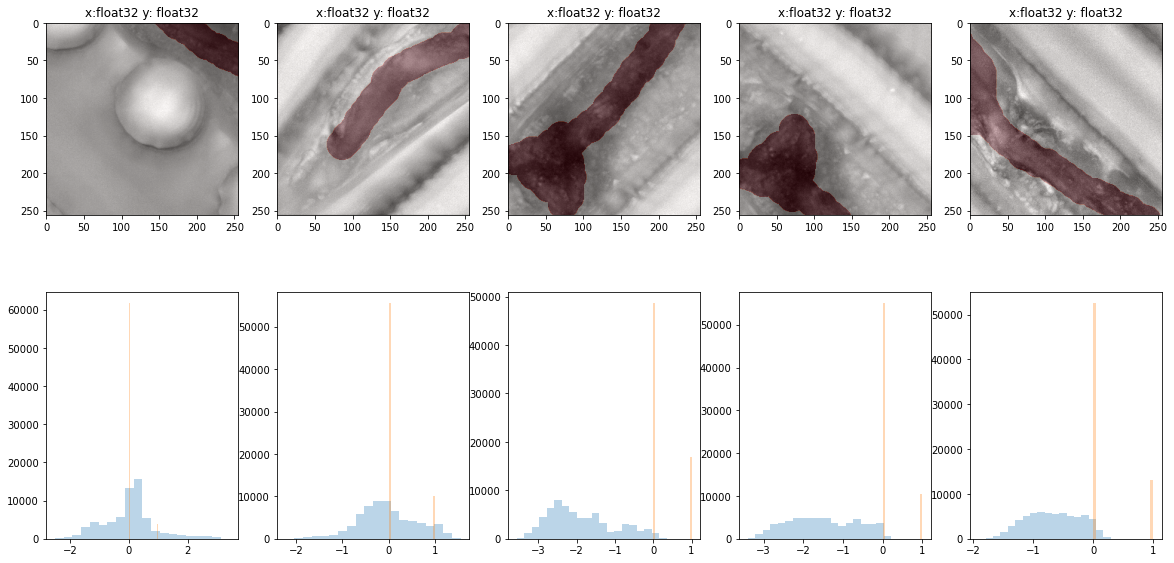

In [13]:
x = image_generator.next()
y = mask_generator.next()

print('x batch:', x.shape)
print('y batch:', y.shape)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 1 row, 5 columns

for i in range(5):
    # show grayscale images

    ri = np.random.randint(0,32)
    axs[0,i].imshow(x[ri,...,0], cmap='gray')
    axs[0,i].imshow(y[ri,...,0], cmap='Reds', alpha=0.3)
    axs[0,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
#     axs[1,i].imshow(x[ri+1,...,0], cmap='gray')
#     axs[1,i].imshow(y[i+1,...,0], cmap='Reds', alpha=0.3)
#     axs[1,i].title.set_text('x:{} y: {}'.format(x[ri,...,0].dtype,y[ri,...,0].dtype))
    
    axs[1,i].hist(x[ri,...,0].flatten(), bins = 20,alpha = 0.3)
    axs[1,i].hist(y[ri,...,0].flatten(), bins = 20,alpha = 0.3)

plt.show()

In [12]:
x.shape

(32, 256, 256, 2)

In [14]:
N = x.shape[-1]

# define the model
BACKBONE = 'resnet18'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet',encoder_freeze=False)
inp = Input(shape =(None,None, N))
l1 = Conv2D(3,(1,1))(inp) # map N channels data to 3 channels
out = base_model(l1)
model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

# checkpoint path
checkpoint_path = 'bfg_to_gut_backresnet18_exp2_v1.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True,mode='min')

# logdirectory
log_fname = 'bfg_to_gut_backresnet18_exp2_v1.csv'
csvlogger = CSVLogger(filename=log_fname, separator=",", append=True)

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 2)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 3)     9         
_________________________________________________________________
model_1 (Model)              (None, None, None, 1)     14340570  
Total params: 14,340,579
Trainable params: 14,330,653
Non-trainable params: 9,926
_________________________________________________________________


In [16]:
model.load_weights('bfg_to_gut_backresnet18_v1.h5')

In [17]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=10,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/10
22/22 [==============================] - 20s 929ms/step - loss: 0.6368 - iou_score: 0.5493 - val_loss: 0.9159 - val_iou_score: 0.5519
Epoch 2/10
22/22 [==============================] - 13s 600ms/step - loss: 0.5530 - iou_score: 0.6009 - val_loss: 0.7711 - val_iou_score: 0.5537
Epoch 3/10
22/22 [==============================] - 14s 632ms/step - loss: 0.5168 - iou_score: 0.6206 - val_loss: 0.6919 - val_iou_score: 0.5800
Epoch 4/10
22/22 [==============================] - 13s 587ms/step - loss: 0.4259 - iou_score: 0.6778 - val_loss: 0.7367 - val_iou_score: 0.5527
Epoch 5/10
22/22 [==============================] - 13s 580ms/step - loss: 0.4740 - iou_score: 0.6569 - val_loss: 0.6820 - val_iou_score: 0.5589
Epoch 6/10
22/22 [==============================] - 13s 604ms/step - loss: 0.4391 - iou_score: 0.6849 - val_loss: 0.6449 - val_iou_score: 0.5811
Epoch 7/10
22/22 [==============================] - 13s 580ms/step - loss: 0.4026 - iou_score: 0.7040 - val_loss: 0.5028 - val_iou

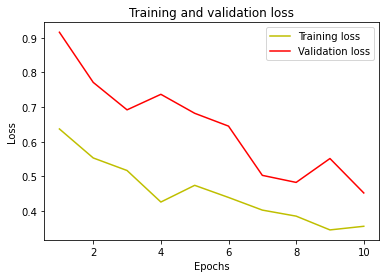

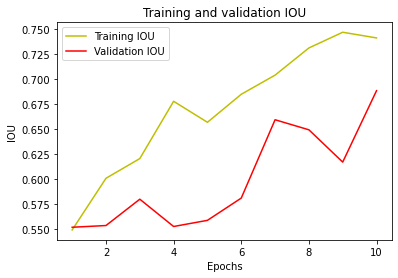

IoU socre is:  0.7547399050965539


In [18]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


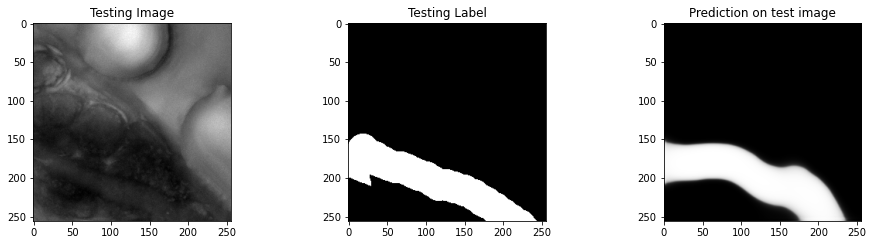

In [19]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [20]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=20,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/20
22/22 [==============================] - 13s 594ms/step - loss: 0.2796 - iou_score: 0.7884 - val_loss: 0.4502 - val_iou_score: 0.6911
Epoch 2/20
22/22 [==============================] - 13s 589ms/step - loss: 0.3393 - iou_score: 0.7641 - val_loss: 0.3847 - val_iou_score: 0.7286
Epoch 3/20
22/22 [==============================] - 12s 543ms/step - loss: 0.2893 - iou_score: 0.7930 - val_loss: 0.4115 - val_iou_score: 0.7157
Epoch 4/20
22/22 [==============================] - 13s 582ms/step - loss: 0.2825 - iou_score: 0.7930 - val_loss: 0.3607 - val_iou_score: 0.7266
Epoch 5/20
22/22 [==============================] - 13s 572ms/step - loss: 0.2847 - iou_score: 0.8052 - val_loss: 0.3518 - val_iou_score: 0.7527
Epoch 6/20
22/22 [==============================] - 13s 581ms/step - loss: 0.2522 - iou_score: 0.8183 - val_loss: 0.3447 - val_iou_score: 0.7556
Epoch 7/20
22/22 [==============================] - 12s 539ms/step - loss: 0.2639 - iou_score: 0.8126 - val_loss: 0.3564 - val_iou

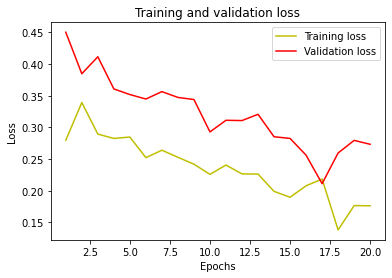

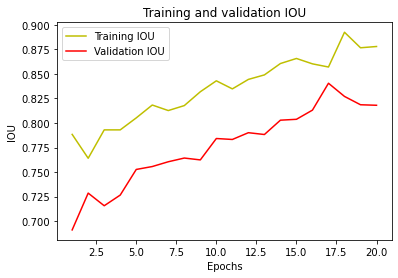

IoU socre is:  0.8667986612216848


In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


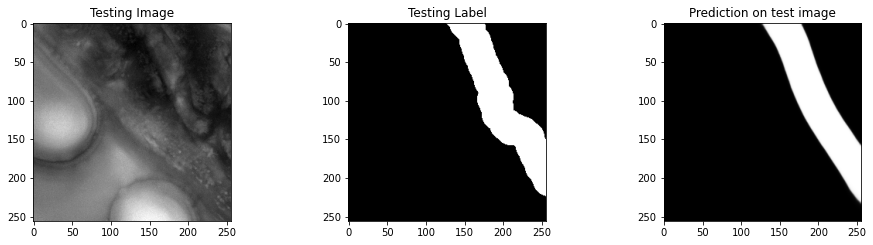

In [22]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [23]:
#Fit the model
history = model.fit(train_gen,
                    validation_data=test_gen,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps=len(X_train) // batch_size,
                    epochs=10,
                    callbacks=[checkpoint,csvlogger])

Epoch 1/10
22/22 [==============================] - 12s 556ms/step - loss: 0.1272 - iou_score: 0.9006 - val_loss: 0.2614 - val_iou_score: 0.8284
Epoch 2/10
22/22 [==============================] - 12s 540ms/step - loss: 0.1906 - iou_score: 0.8771 - val_loss: 0.2400 - val_iou_score: 0.8233
Epoch 3/10
22/22 [==============================] - 12s 530ms/step - loss: 0.1713 - iou_score: 0.8836 - val_loss: 0.2548 - val_iou_score: 0.8276
Epoch 4/10
22/22 [==============================] - 11s 518ms/step - loss: 0.1775 - iou_score: 0.8819 - val_loss: 0.2651 - val_iou_score: 0.8278
Epoch 5/10
22/22 [==============================] - 12s 536ms/step - loss: 0.1913 - iou_score: 0.8793 - val_loss: 0.2562 - val_iou_score: 0.8272
Epoch 6/10
22/22 [==============================] - 12s 542ms/step - loss: 0.1708 - iou_score: 0.8863 - val_loss: 0.2509 - val_iou_score: 0.8267
Epoch 7/10
22/22 [==============================] - 12s 545ms/step - loss: 0.1769 - iou_score: 0.8811 - val_loss: 0.2445 - val_iou

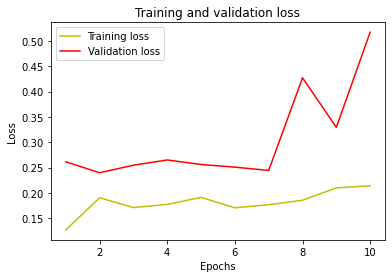

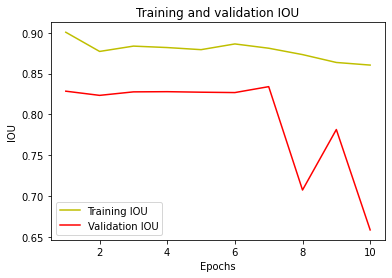

IoU socre is:  0.6742965043687371


In [24]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

(256, 256, 2)


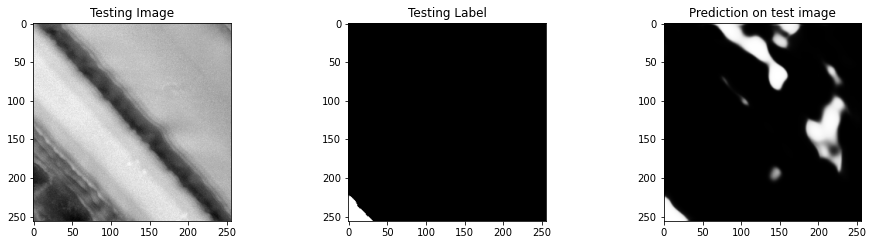

In [25]:
test_img_number = np.random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
print(test_img.shape)
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()